In [380]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM
from keras.layers.core import Activation
from keras.utils import pad_sequences

In [381]:
# Load the data
df = pd.read_csv('../Data/cleaned_Pond2.csv', delimiter=',', low_memory=False )

In [382]:
df.drop("Unnamed: 0",axis=1,inplace=True)
df.drop("Population",axis=1,inplace=True)
df.drop("Date",axis=1,inplace=True)
df.drop("Time",axis=1,inplace=True)
df.drop("Weight_diff",axis=1,inplace=True)
df.drop("Fish_Length",axis=1,inplace=True)
df.drop("Fish_Weight",axis=1,inplace=True)
df.head(5)

,Temperature,Turbidity,Dissolved Oxygen,PH,Ammonia,Nitrate,Datetime
0,24.8750,100,4.505,8.43365,0.38,193,2021-06-19 00:00:05
1,24.9375,100,6.601,8.43818,0.38,194,2021-06-19 00:01:02
2,24.8750,100,15.797,8.42457,0.38,192,2021-06-19 00:01:22
3,24.9375,100,5.046,8.43365,0.38,193,2021-06-19 00:01:44
4,24.9375,100,38.407,8.40641,0.38,192,2021-06-19 00:02:07


In [383]:
df['Datetime'] = pd.to_datetime(df.Datetime,infer_datetime_format=True)
df.set_index("Datetime",inplace=True)
df=df.resample('min').ffill()
df=df.bfill()

In [384]:
df.head(5)

,Temperature,Turbidity,Dissolved Oxygen,PH,Ammonia,Nitrate
Datetime,,,,,,
2021-06-19 00:00:00,24.8750,100.0,4.505,8.43365,0.38,193.0
2021-06-19 00:01:00,24.8750,100.0,4.505,8.43365,0.38,193.0
2021-06-19 00:02:00,24.9375,100.0,5.046,8.43365,0.38,193.0
2021-06-19 00:03:00,24.8750,100.0,2.831,8.43818,0.38,194.0
2021-06-19 00:04:00,24.8750,100.0,17.005,8.43365,0.38,192.0


In [385]:
df.describe()

,Temperature,Turbidity,Dissolved Oxygen,PH,Ammonia,Nitrate
count,192960.00000,192960.000000,192960.000000,192960.000000,1.929600e+05,192960.000000
mean,24.90110,95.079519,6.784840,5.186690,1.644444e+08,749.050643
std,0.82809,16.312601,9.219671,3.238303,8.591875e+09,408.174637
min,23.00000,1.000000,0.007000,-3.137450,6.770000e-03,61.000000
25%,24.25000,100.000000,2.163000,2.446090,8.196800e-01,204.000000
50%,24.81250,100.000000,3.200000,7.003710,5.979360e+00,938.000000
75%,25.43750,100.000000,6.795000,7.421340,2.608377e+01,1072.000000
max,27.81250,100.000000,41.011000,8.551670,9.965130e+11,2077.000000


In [386]:
def percentage(percent, whole):
  return (percent * whole) / 100.0

In [387]:
chunk_prctg=1
training_prctg=80
validation_prctg=20

rows_to_work_with=round(percentage(chunk_prctg, df.shape[0]))
print('rows_to_work_with ',rows_to_work_with)
training_rows_to_work_with=round(percentage(training_prctg, rows_to_work_with))
print('training_rows_to_work_with',training_rows_to_work_with)

rows_to_work_with  1930
training_rows_to_work_with 1544


In [388]:
# It does not make sense to randomize our data . In machine learning, train/test split splits the data randomly, 
# as there’s no dependence from one observation to the other. That’s not the case with our time series data.
# Here, we’ll want to use values at the rear of the dataset for testing and everything else for training.
# create your training and validation sets here
start_index=0
train_df = df[start_index:training_rows_to_work_with]
val_df = df[training_rows_to_work_with:rows_to_work_with]

<AxesSubplot:>

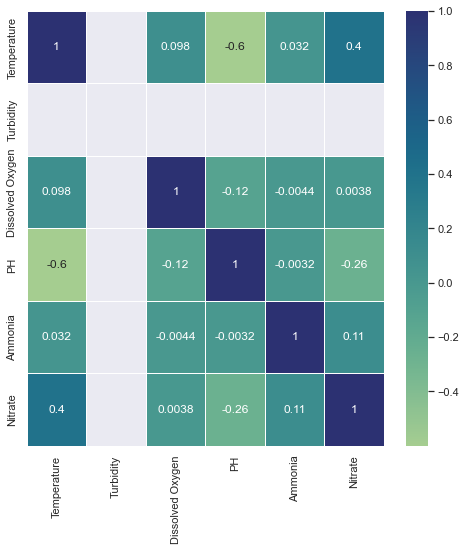

In [389]:
import seaborn as sns; sns.set()
plt.figure(figsize=(8,8))
sns.heatmap(train_df.corr(), annot=True, cmap='crest',linewidth=.5  )

In [390]:
# #  Importing the dataset (Original Cleaned Dataset)
# train_df = pd.read_csv('../Data/train_df.csv')
# val_df = pd.read_csv('../Data/val_df.csv')

Temperature Predictions: 

In [391]:
# X_train = train_df.drop("Temperature",axis=1)
X_train = train_df[['Temperature','PH']]
y_train = train_df['Temperature']
# X_test = val_df.drop("Temperature",axis=1)
X_test = val_df[['Temperature','PH']]

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on your training data
scaler.fit(X_train)

X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)


Preparing our Training Data sequences with label predictions

In [392]:
# we'll start out with a 2 minute input sequence and a one minute predictive horizon
seq_arrays = []
seq_labs = []
seq_length = 2
ph = 1


num_train_rows=train_df.shape[0]

#create list of sequence length Temperature readings
for start in range(0,num_train_rows-seq_length-ph):
    seq_arrays.append(X_train_norm[start:start+seq_length])
#     seq_arrays.append(train_df[feat_cols].iloc[start:start+seq_length].to_numpy())
    seq_labs.append([train_df['Temperature'].iloc[start:start+seq_length+1].to_numpy()[-1]])

seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)

In [393]:
seq_arrays.shape

(1541, 2, 2)

In [394]:
seq_labs.shape

(1541, 1)

Preparing our Test Data sequences with label predictions

In [395]:
val_arrays = []
val_labs = []

num_test_rows=val_df.shape[0]

i=1

#create list of Temperature readings starting with a minimum of two readings
for start in range(2,num_test_rows):
    incoming_df=val_df[0:start] 
    
    if len(incoming_df) > seq_length: 
        
        val_arrays.append(X_test_norm[i:i+seq_length])
        val_labs.append([incoming_df['Temperature'].iloc[i:i+seq_length+ph].to_numpy()[-1]])
        i+=1
        
    else:
        
        val_arrays.append(X_test_norm[0:len(incoming_df)])
        val_labs.append([incoming_df['Temperature'].iloc[0:len(incoming_df)+ph].to_numpy()[-1]])
        
# use the pad_sequences function on your input sequences
val_arrays = tf.keras.preprocessing.sequence.pad_sequences(val_arrays, dtype='float32', padding='post',value=val_df["Temperature"].mean())     

#convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype = object).astype(np.float32)

In [396]:
val_arrays.shape

(384, 2, 2)

In [397]:
val_labs.shape

(384, 1)



## Model Training

We will begin with a model architecture very similar to the model we built in the lab session. We will have two LSTM layers, with 5 and 3 hidden units respectively, and we will apply dropout after each LSTM layer. However, we will use a linear final layer and MSE for our loss function, since our output is continuous instead of binary.


CNN-LSTM Model

In [398]:
from keras.layers import Conv1D, BatchNormalization
model_path = './Models/CNN_LSTM_model_temperature.h5'
# build the network
nb_features = seq_arrays.shape[2]
nb_out = seq_labs.shape[1]
model = Sequential()

model.add(Conv1D(32,input_shape=(seq_length, nb_features),kernel_size=2, padding="causal",activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv1D(48,kernel_size=2,padding="causal",activation="relu",dilation_rate=2))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv1D(64,kernel_size=2,padding="causal",activation="relu",dilation_rate=4))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(LSTM(50))
model.add(Dropout(0.2))

model.add(Dense(units = nb_out))
model.add(Activation("linear"))
optimizer = keras.optimizers.Adam(learning_rate = 0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])
print(model.summary())

Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_153 (Conv1D)         (None, 2, 32)             160       
                                                                 
 batch_normalization_153 (Ba  (None, 2, 32)            128       
 tchNormalization)                                               
                                                                 
 dropout_208 (Dropout)       (None, 2, 32)             0         
                                                                 
 conv1d_154 (Conv1D)         (None, 2, 48)             3120      
                                                                 
 batch_normalization_154 (Ba  (None, 2, 48)            192       
 tchNormalization)                                               
                                                                 
 dropout_209 (Dropout)       (None, 2, 48)           

In [399]:
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=50,validation_split=0.05, verbose=2,
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0, patience=10, verbose=0, mode='min'),
keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True,mode='min', verbose=0)])
# list all data in history
print(history.history.keys())

Epoch 1/100
30/30 - 6s - loss: 608.3169 - mse: 608.3168 - val_loss: 645.8455 - val_mse: 645.8455 - 6s/epoch - 187ms/step
Epoch 2/100
30/30 - 0s - loss: 484.8766 - mse: 484.8766 - val_loss: 537.4619 - val_mse: 537.4619 - 238ms/epoch - 8ms/step
Epoch 3/100
30/30 - 0s - loss: 394.6516 - mse: 394.6516 - val_loss: 397.6600 - val_mse: 397.6600 - 227ms/epoch - 8ms/step
Epoch 4/100
30/30 - 0s - loss: 336.4415 - mse: 336.4415 - val_loss: 314.3679 - val_mse: 314.3679 - 248ms/epoch - 8ms/step
Epoch 5/100
30/30 - 0s - loss: 292.3426 - mse: 292.3426 - val_loss: 255.3759 - val_mse: 255.3759 - 248ms/epoch - 8ms/step
Epoch 6/100
30/30 - 0s - loss: 256.5938 - mse: 256.5938 - val_loss: 204.9669 - val_mse: 204.9669 - 228ms/epoch - 8ms/step
Epoch 7/100
30/30 - 0s - loss: 222.6049 - mse: 222.6049 - val_loss: 159.1083 - val_mse: 159.1083 - 221ms/epoch - 7ms/step
Epoch 8/100
30/30 - 0s - loss: 183.6427 - mse: 183.6427 - val_loss: 123.0119 - val_mse: 123.0119 - 222ms/epoch - 7ms/step
Epoch 9/100
30/30 - 0s - 

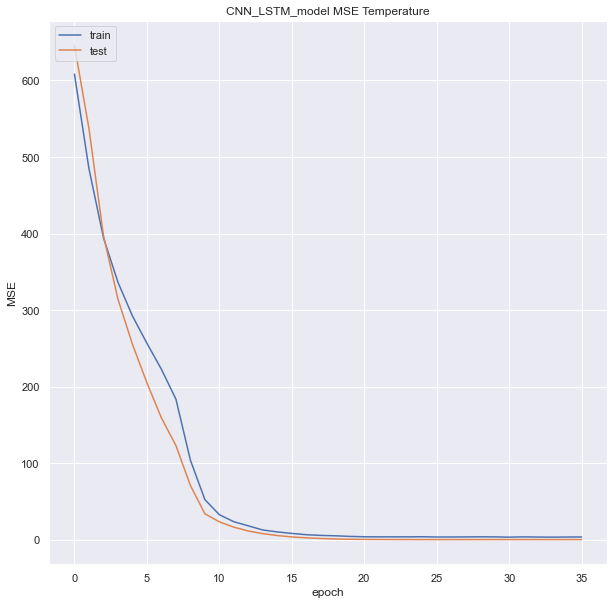

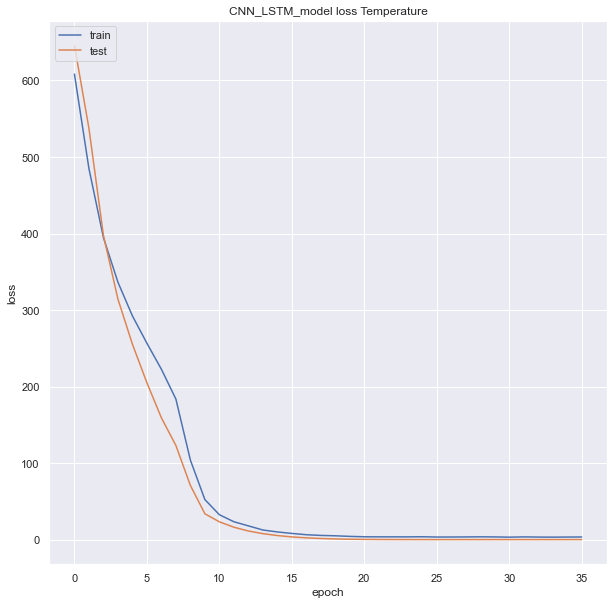

In [400]:
# summarize history for MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('CNN_LSTM_model MSE Temperature')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("./Images/CNN_LSTM_mse_temperature.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN_LSTM_model loss Temperature')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("./Images/CNN_LSTM_loss_temperature.png")


We will now run this validation data through our CNN-LSTM model and visualize its performance 

12/12 - 0s - loss: 0.3456 - mse: 0.3456 - 87ms/epoch - 7ms/step

MSE: 0.3456357419490814
12/12 [==============================] - 1s 2ms/step


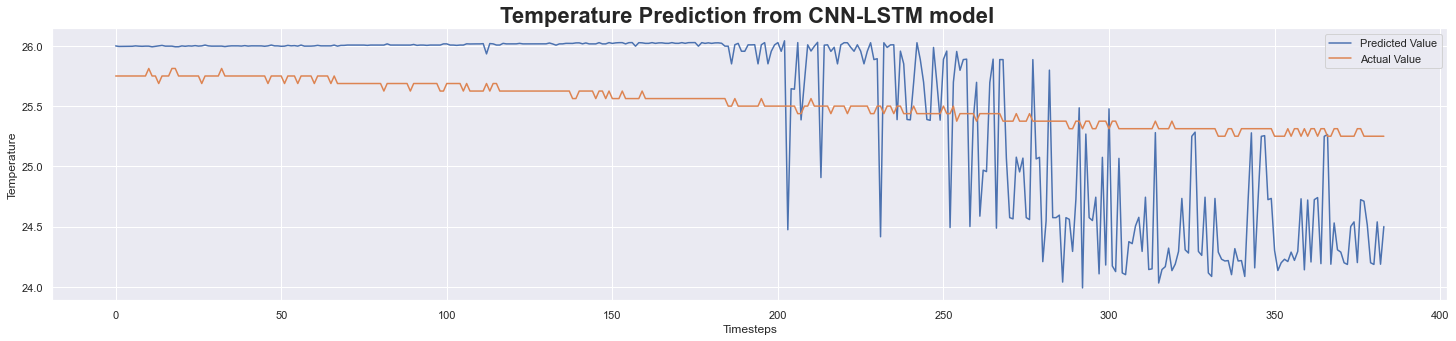

In [401]:
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('./Predictions/temperature_predictions.csv', index = None)

# Plot the predicted data vs. the actual data
# we will limit our plot to the first 200 predictions for better visualization
fig_verify = plt.figure(figsize=(25, 5))
# plt.plot(y_pred_test[-100:], label = 'Predicted Value')
# plt.plot(y_true_test[-100:], label = 'Actual Value')
plt.plot(y_pred_test, label = 'Predicted Value')
plt.plot(y_true_test, label = 'Actual Value')
plt.title('Temperature Prediction from CNN-LSTM model ', fontsize=22, fontweight='bold')
plt.ylabel('Temperature')
plt.xlabel('Timesteps')
plt.legend()
plt.show()
fig_verify.savefig("./Images/temperature_predictions.png")

pH Predictions

In [402]:
# X_train = train_df.drop("Temperature",axis=1)
X_train = train_df[['Temperature','PH']]
y_train = train_df['PH']
# X_test = val_df.drop("Temperature",axis=1)
X_test = val_df[['Temperature','PH']]

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on your training data
scaler.fit(X_train)

X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

In [403]:
# we'll start out with a 2 minute input sequence and a one minute predictive horizon
seq_arrays = []
seq_labs = []
seq_length = 2
ph = 1


num_train_rows=train_df.shape[0]

#create list of sequence length Temperature readings
for start in range(0,num_train_rows-seq_length-ph):
    seq_arrays.append(X_train_norm[start:start+seq_length])
#     seq_arrays.append(train_df[feat_cols].iloc[start:start+seq_length].to_numpy())
    seq_labs.append([train_df['PH'].iloc[start:start+seq_length+1].to_numpy()[-1]])

seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)

In [404]:
val_arrays = []
val_labs = []

num_test_rows=val_df.shape[0]

i=1

#create list of Temperature readings starting with a minimum of two readings
for start in range(2,num_test_rows):
    incoming_df=val_df[0:start] 
    
    if len(incoming_df) > seq_length: 
        
        val_arrays.append(X_test_norm[i:i+seq_length])
        val_labs.append([incoming_df['PH'].iloc[i:i+seq_length+ph].to_numpy()[-1]])
        i+=1
        
    else:
        
        val_arrays.append(X_test_norm[0:len(incoming_df)])
        val_labs.append([incoming_df['PH'].iloc[0:len(incoming_df)+ph].to_numpy()[-1]])
        
# use the pad_sequences function on your input sequences
val_arrays = tf.keras.preprocessing.sequence.pad_sequences(val_arrays, dtype='float32', padding='post',value=val_df["PH"].mean())     

#convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype = object).astype(np.float32)

In [405]:
print(val_arrays.shape,val_labs.shape,seq_arrays.shape,seq_labs.shape)

(384, 2, 2) (384, 1) (1541, 2, 2) (1541, 1)


In [406]:
from keras.layers import Conv1D, BatchNormalization
model_path = './Models/CNN_LSTM_model_pH.h5'
# build the network
nb_features = seq_arrays.shape[2]
nb_out = seq_labs.shape[1]
model = Sequential()

model.add(Conv1D(32,input_shape=(seq_length, nb_features),kernel_size=2, padding="causal",activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv1D(48,kernel_size=2,padding="causal",activation="relu",dilation_rate=2))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv1D(64,kernel_size=2,padding="causal",activation="relu",dilation_rate=4))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(LSTM(50))
model.add(Dropout(0.2))

model.add(Dense(units = nb_out))
model.add(Activation("linear"))
optimizer = keras.optimizers.Adam(learning_rate = 0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])
print(model.summary())

Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_156 (Conv1D)         (None, 2, 32)             160       
                                                                 
 batch_normalization_156 (Ba  (None, 2, 32)            128       
 tchNormalization)                                               
                                                                 
 dropout_212 (Dropout)       (None, 2, 32)             0         
                                                                 
 conv1d_157 (Conv1D)         (None, 2, 48)             3120      
                                                                 
 batch_normalization_157 (Ba  (None, 2, 48)            192       
 tchNormalization)                                               
                                                                 
 dropout_213 (Dropout)       (None, 2, 48)           

In [407]:
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=50,validation_split=0.05, verbose=2,
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0, patience=10, verbose=0, mode='min'),
keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True,mode='min', verbose=0)])
# list all data in history
print(history.history.keys())

Epoch 1/100
30/30 - 5s - loss: 60.9895 - mse: 60.9895 - val_loss: 64.3793 - val_mse: 64.3793 - 5s/epoch - 178ms/step
Epoch 2/100
30/30 - 0s - loss: 29.3509 - mse: 29.3509 - val_loss: 44.0886 - val_mse: 44.0886 - 365ms/epoch - 12ms/step
Epoch 3/100
30/30 - 0s - loss: 5.8126 - mse: 5.8126 - val_loss: 14.3689 - val_mse: 14.3689 - 329ms/epoch - 11ms/step
Epoch 4/100
30/30 - 0s - loss: 1.0448 - mse: 1.0448 - val_loss: 3.5242 - val_mse: 3.5242 - 307ms/epoch - 10ms/step
Epoch 5/100
30/30 - 0s - loss: 0.5987 - mse: 0.5987 - val_loss: 1.1739 - val_mse: 1.1739 - 336ms/epoch - 11ms/step
Epoch 6/100
30/30 - 0s - loss: 0.5774 - mse: 0.5774 - val_loss: 0.3980 - val_mse: 0.3980 - 244ms/epoch - 8ms/step
Epoch 7/100
30/30 - 0s - loss: 0.5737 - mse: 0.5737 - val_loss: 0.1247 - val_mse: 0.1247 - 238ms/epoch - 8ms/step
Epoch 8/100
30/30 - 0s - loss: 0.5396 - mse: 0.5396 - val_loss: 0.0224 - val_mse: 0.0224 - 338ms/epoch - 11ms/step
Epoch 9/100
30/30 - 0s - loss: 0.5146 - mse: 0.5146 - val_loss: 0.0068 - v

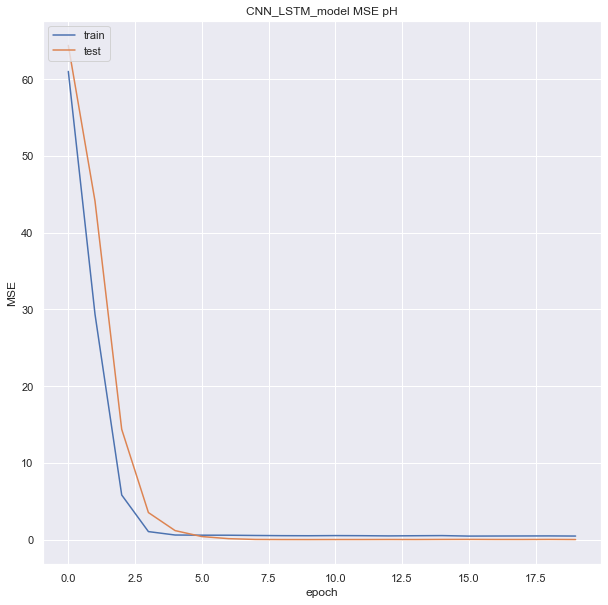

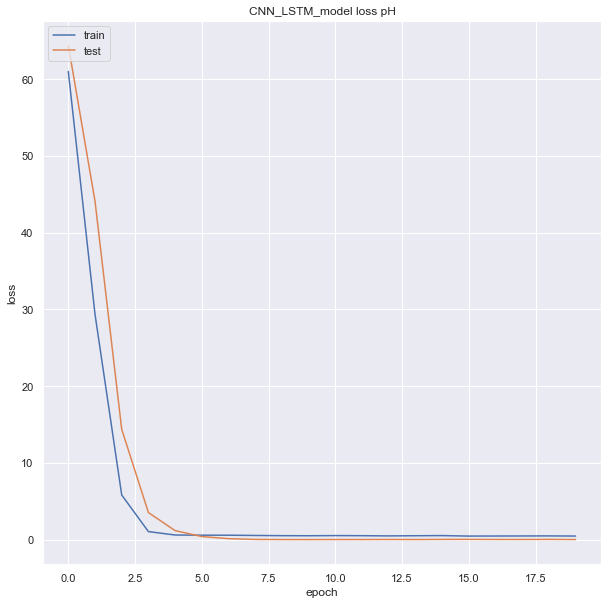

In [408]:
# summarize history for MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('CNN_LSTM_model MSE pH')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("./Images/CNN_LSTM_mse_pH.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN_LSTM_model loss pH')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("./Images/CNN_LSTM_loss_pH.png")


12/12 - 0s - loss: 0.0021 - mse: 0.0021 - 54ms/epoch - 4ms/step

MSE: 0.0021234420128166676
12/12 [==============================] - 1s 2ms/step


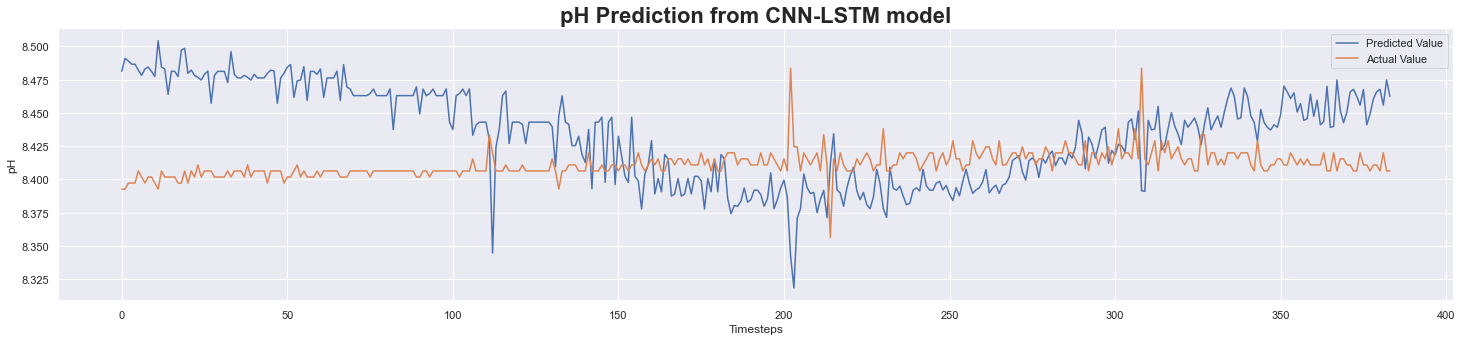

In [409]:
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('./Predictions/pH_predictions.csv', index = None)

# Plot the predicted data vs. the actual data
# we will limit our plot to the first 200 predictions for better visualization
fig_verify = plt.figure(figsize=(25, 5))
# plt.plot(y_pred_test[-100:], label = 'Predicted Value')
# plt.plot(y_true_test[-100:], label = 'Actual Value')
plt.plot(y_pred_test, label = 'Predicted Value')
plt.plot(y_true_test, label = 'Actual Value')
plt.title('pH Prediction from CNN-LSTM model', fontsize=22, fontweight='bold')
plt.ylabel('pH')
plt.xlabel('Timesteps')
plt.legend()
plt.show()
fig_verify.savefig("./Images/pH_Predictions.png")

Turbidity Predictions

In [443]:
# Turbidity
X_train = train_df[['Turbidity']]
y_train = train_df['Turbidity']
# X_test = val_df.drop("Temperature",axis=1)
X_test = val_df[['Turbidity']]

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on your training data
scaler.fit(X_train)

X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

In [444]:
# we'll start out with a 2 minute input sequence and a one minute predictive horizon
seq_arrays = []
seq_labs = []
seq_length = 2
ph = 1


num_train_rows=train_df.shape[0]

#create list of sequence length Temperature readings
for start in range(0,num_train_rows-seq_length-ph):
    seq_arrays.append(X_train_norm[start:start+seq_length])
#     seq_arrays.append(train_df[feat_cols].iloc[start:start+seq_length].to_numpy())
    seq_labs.append([train_df['Turbidity'].iloc[start:start+seq_length+1].to_numpy()[-1]])

seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)

In [445]:
val_arrays = []
val_labs = []

num_test_rows=val_df.shape[0]

i=1

#create list of Temperature readings starting with a minimum of two readings
for start in range(2,num_test_rows):
    incoming_df=val_df[0:start] 
    
    if len(incoming_df) > seq_length: 
        
        val_arrays.append(X_test_norm[i:i+seq_length])
        val_labs.append([incoming_df['Turbidity'].iloc[i:i+seq_length+ph].to_numpy()[-1]])
        i+=1
        
    else:
        
        val_arrays.append(X_test_norm[0:len(incoming_df)])
        val_labs.append([incoming_df['Turbidity'].iloc[0:len(incoming_df)+ph].to_numpy()[-1]])
        
# use the pad_sequences function on your input sequences
val_arrays = tf.keras.preprocessing.sequence.pad_sequences(val_arrays, dtype='float32', padding='post',value=val_df["PH"].mean())     

#convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype = object).astype(np.float32)

In [446]:
print(val_arrays.shape,val_labs.shape,seq_arrays.shape,seq_labs.shape)

(384, 2, 1) (384, 1) (1541, 2, 1) (1541, 1)


In [447]:
from keras.layers import Conv1D, BatchNormalization
model_path = './Models/CNN_LSTM_model_turbidity.h5'
# build the network
nb_features = seq_arrays.shape[2]
nb_out = seq_labs.shape[1]
model = Sequential()

model.add(Conv1D(32,input_shape=(seq_length, nb_features),kernel_size=2, padding="causal",activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv1D(48,kernel_size=2,padding="causal",activation="relu",dilation_rate=2))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv1D(64,kernel_size=2,padding="causal",activation="relu",dilation_rate=4))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(LSTM(50))
model.add(Dropout(0.2))

model.add(Dense(units = nb_out))
model.add(Activation("linear"))
optimizer = keras.optimizers.Adam(learning_rate = 0.01)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])
print(model.summary())

Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_170 (Conv1D)         (None, 2, 32)             96        
                                                                 
 batch_normalization_170 (Ba  (None, 2, 32)            128       
 tchNormalization)                                               
                                                                 
 dropout_231 (Dropout)       (None, 2, 32)             0         
                                                                 
 conv1d_171 (Conv1D)         (None, 2, 48)             3120      
                                                                 
 batch_normalization_171 (Ba  (None, 2, 48)            192       
 tchNormalization)                                               
                                                                 
 dropout_232 (Dropout)       (None, 2, 48)           

In [448]:
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=100,validation_split=0.05, verbose=2,
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0, patience=10, verbose=0, mode='min'),
keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True,mode='min', verbose=0)])
# list all data in history
print(history.history.keys())

Epoch 1/100
15/15 - 4s - loss: 9176.4932 - mse: 9176.4932 - val_loss: 7444.7236 - val_mse: 7444.7236 - 4s/epoch - 277ms/step
Epoch 2/100
15/15 - 0s - loss: 6734.9141 - mse: 6734.9141 - val_loss: 5958.5361 - val_mse: 5958.5361 - 201ms/epoch - 13ms/step
Epoch 3/100
15/15 - 0s - loss: 5391.2749 - mse: 5391.2749 - val_loss: 4763.0947 - val_mse: 4763.0947 - 203ms/epoch - 14ms/step
Epoch 4/100
15/15 - 0s - loss: 4308.9404 - mse: 4308.9404 - val_loss: 3779.8218 - val_mse: 3779.8218 - 209ms/epoch - 14ms/step
Epoch 5/100
15/15 - 0s - loss: 3410.2104 - mse: 3410.2104 - val_loss: 2977.5691 - val_mse: 2977.5691 - 195ms/epoch - 13ms/step
Epoch 6/100
15/15 - 0s - loss: 2677.6455 - mse: 2677.6455 - val_loss: 2325.2578 - val_mse: 2325.2578 - 223ms/epoch - 15ms/step
Epoch 7/100
15/15 - 0s - loss: 2097.7454 - mse: 2097.7454 - val_loss: 1798.1147 - val_mse: 1798.1147 - 194ms/epoch - 13ms/step
Epoch 8/100
15/15 - 0s - loss: 1613.0554 - mse: 1613.0554 - val_loss: 1375.5072 - val_mse: 1375.5072 - 227ms/epoc

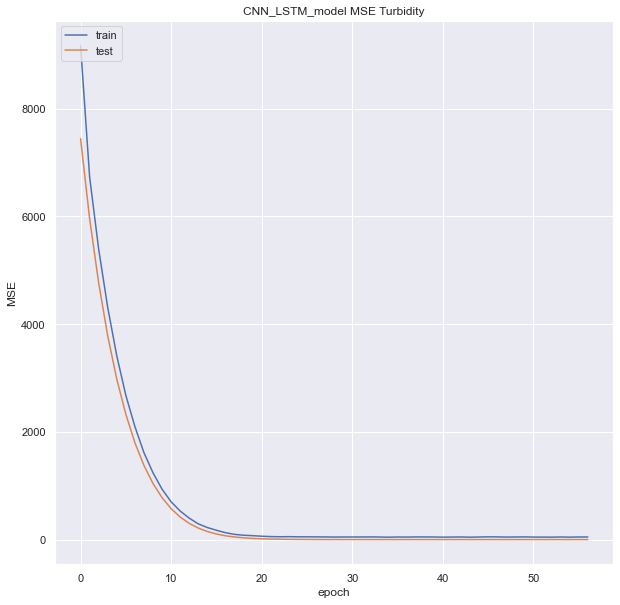

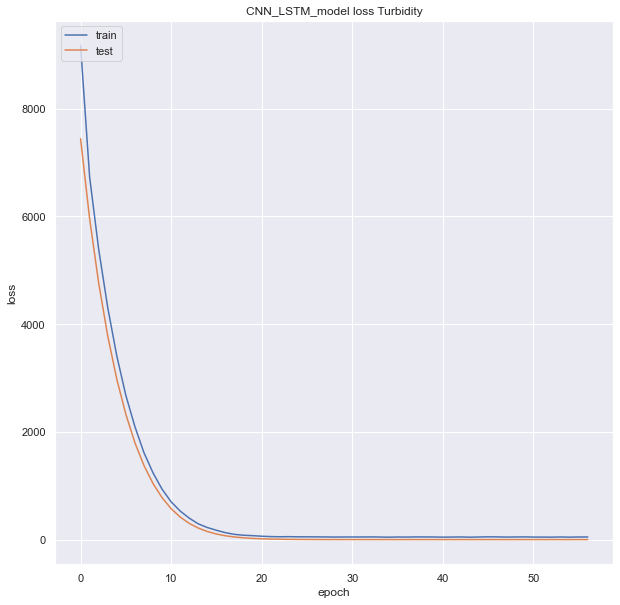

In [449]:
# summarize history for MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('CNN_LSTM_model MSE Turbidity')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("./Images/CNN_LSTM_mse_turbidity.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN_LSTM_model loss Turbidity')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("./Images/CNN_LSTM_loss_turbidity.png")

12/12 - 0s - loss: 0.2467 - mse: 0.2467 - 67ms/epoch - 6ms/step

MSE: 0.24666951596736908
12/12 [==============================] - 1s 2ms/step


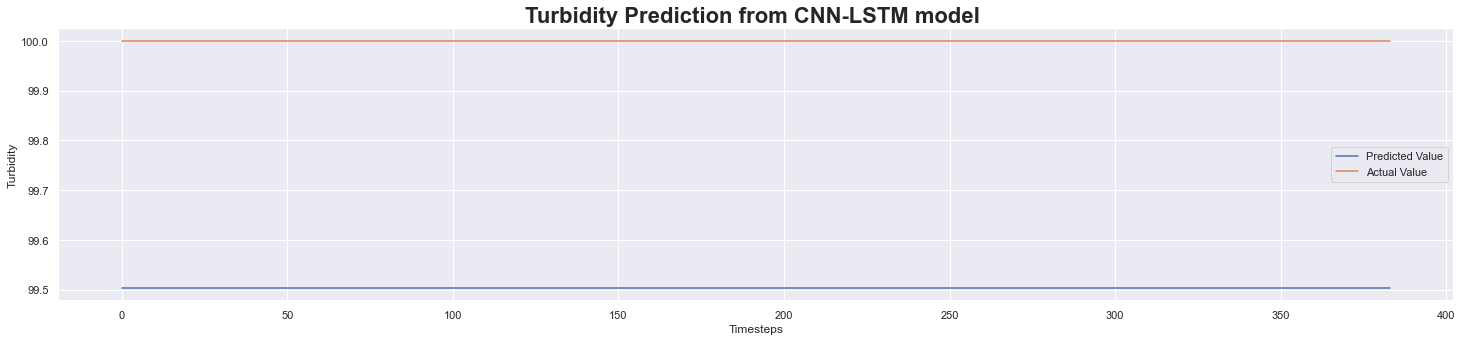

In [450]:
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('./Predictions/turbidity_predictions.csv', index = None)

# Plot the predicted data vs. the actual data
# we will limit our plot to the first 200 predictions for better visualization
fig_verify = plt.figure(figsize=(25, 5))
# plt.plot(y_pred_test[-100:], label = 'Predicted Value')
# plt.plot(y_true_test[-100:], label = 'Actual Value')
plt.plot(y_pred_test, label = 'Predicted Value')
plt.plot(y_true_test, label = 'Actual Value')
plt.title('Turbidity Prediction from CNN-LSTM model ', fontsize=22, fontweight='bold')
plt.ylabel('Turbidity')
plt.xlabel('Timesteps')
plt.legend()
plt.show()
fig_verify.savefig("./Images/turbidity_predictions.png")

Dissolved Oxygen Predictions


In [466]:
# Turbidity
# X_train = train_df[['Temperature','Dissolved Oxygen']]
X_train = train_df[['Dissolved Oxygen']]
y_train = train_df['Dissolved Oxygen']
# X_test = val_df[['Temperature','Dissolved Oxygen']]
X_test = val_df[['Dissolved Oxygen']]

# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()

# # Fit the scaler on your training data
# scaler.fit(X_train)

# X_train_norm = scaler.transform(X_train)
# X_test_norm = scaler.transform(X_test)

X_train_norm = X_train
X_test_norm = X_test


In [467]:
# we'll start out with a 2 minute input sequence and a one minute predictive horizon
seq_arrays = []
seq_labs = []
seq_length = 2
ph = 1


num_train_rows=train_df.shape[0]

#create list of sequence length Temperature readings
for start in range(0,num_train_rows-seq_length-ph):
    seq_arrays.append(X_train_norm[start:start+seq_length])
#     seq_arrays.append(train_df[feat_cols].iloc[start:start+seq_length].to_numpy())
    seq_labs.append([train_df['Dissolved Oxygen'].iloc[start:start+seq_length+1].to_numpy()[-1]])

seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)

In [468]:
val_arrays = []
val_labs = []

num_test_rows=val_df.shape[0]

i=1

#create list of Temperature readings starting with a minimum of two readings
for start in range(2,num_test_rows):
    incoming_df=val_df[0:start] 
    
    if len(incoming_df) > seq_length: 
        
        val_arrays.append(X_test_norm[i:i+seq_length])
        val_labs.append([incoming_df['Dissolved Oxygen'].iloc[i:i+seq_length+ph].to_numpy()[-1]])
        i+=1
        
    else:
        
        val_arrays.append(X_test_norm[0:len(incoming_df)])
        val_labs.append([incoming_df['Dissolved Oxygen'].iloc[0:len(incoming_df)+ph].to_numpy()[-1]])
        
# use the pad_sequences function on your input sequences
val_arrays = tf.keras.preprocessing.sequence.pad_sequences(val_arrays, dtype='float32', padding='post',value=val_df["PH"].mean())     

#convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype = object).astype(np.float32)

In [469]:
print(val_arrays.shape,val_labs.shape,seq_arrays.shape,seq_labs.shape)

(384, 2, 1) (384, 1) (1541, 2, 1) (1541, 1)


In [470]:
from keras.layers import Conv1D, BatchNormalization
model_path = './Models/CNN_LSTM_model_dissolvedOx.h5'
# build the network
nb_features = seq_arrays.shape[2]
nb_out = seq_labs.shape[1]
model = Sequential()

model.add(Conv1D(32,input_shape=(seq_length, nb_features),kernel_size=2, padding="causal",activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv1D(48,kernel_size=2,padding="causal",activation="relu",dilation_rate=2))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv1D(64,kernel_size=2,padding="causal",activation="relu",dilation_rate=4))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(LSTM(50))
model.add(Dropout(0.2))

model.add(Dense(units = nb_out))
model.add(Activation("linear"))
optimizer = keras.optimizers.Adam(learning_rate = 0.01)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])
print(model.summary())

Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_179 (Conv1D)         (None, 2, 32)             96        
                                                                 
 batch_normalization_179 (Ba  (None, 2, 32)            128       
 tchNormalization)                                               
                                                                 
 dropout_243 (Dropout)       (None, 2, 32)             0         
                                                                 
 conv1d_180 (Conv1D)         (None, 2, 48)             3120      
                                                                 
 batch_normalization_180 (Ba  (None, 2, 48)            192       
 tchNormalization)                                               
                                                                 
 dropout_244 (Dropout)       (None, 2, 48)           

In [471]:
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=50,validation_split=0.05, verbose=2,
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0, patience=10, verbose=0, mode='min'),
keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True,mode='min', verbose=0)])
# list all data in history
print(history.history.keys())

Epoch 1/100
30/30 - 4s - loss: 141.1578 - mse: 141.1578 - val_loss: 101.8893 - val_mse: 101.8893 - 4s/epoch - 150ms/step
Epoch 2/100
30/30 - 0s - loss: 88.9827 - mse: 88.9827 - val_loss: 84.5723 - val_mse: 84.5723 - 246ms/epoch - 8ms/step
Epoch 3/100
30/30 - 0s - loss: 87.1777 - mse: 87.1777 - val_loss: 83.1049 - val_mse: 83.1049 - 242ms/epoch - 8ms/step
Epoch 4/100
30/30 - 0s - loss: 87.3819 - mse: 87.3819 - val_loss: 84.2336 - val_mse: 84.2336 - 172ms/epoch - 6ms/step
Epoch 5/100
30/30 - 0s - loss: 88.6155 - mse: 88.6155 - val_loss: 83.6122 - val_mse: 83.6122 - 200ms/epoch - 7ms/step
Epoch 6/100
30/30 - 0s - loss: 87.3833 - mse: 87.3833 - val_loss: 82.1243 - val_mse: 82.1243 - 256ms/epoch - 9ms/step
Epoch 7/100
30/30 - 0s - loss: 87.2719 - mse: 87.2719 - val_loss: 86.8480 - val_mse: 86.8480 - 174ms/epoch - 6ms/step
Epoch 8/100
30/30 - 0s - loss: 87.0923 - mse: 87.0923 - val_loss: 86.6455 - val_mse: 86.6455 - 177ms/epoch - 6ms/step
Epoch 9/100
30/30 - 0s - loss: 87.8772 - mse: 87.8772

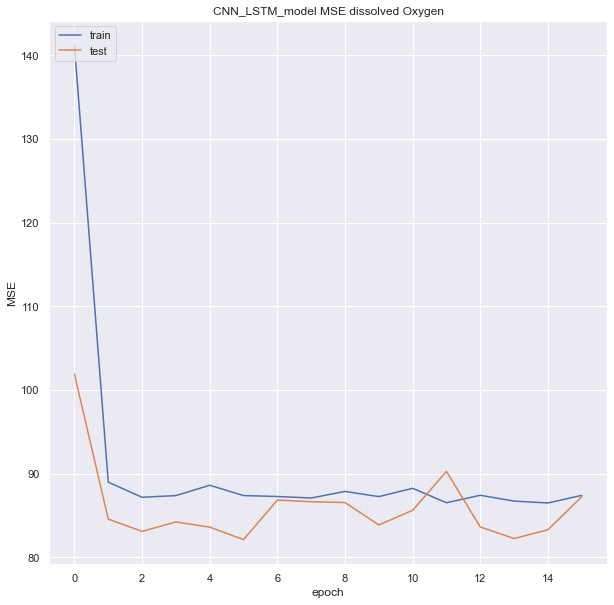

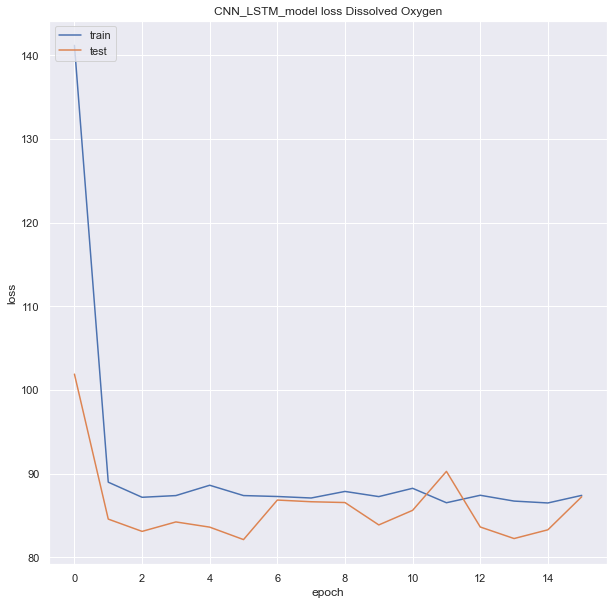

In [472]:
# summarize history for MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('CNN_LSTM_model MSE dissolved Oxygen')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("./Images/CNN_LSTM_mse_dissolvedOx.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN_LSTM_model loss Dissolved Oxygen')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("./Images/CNN_LSTM_loss_dissolvedOx.png")

12/12 - 0s - loss: 85.0106 - mse: 85.0106 - 47ms/epoch - 4ms/step

MSE: 85.01055145263672
12/12 [==============================] - 1s 3ms/step


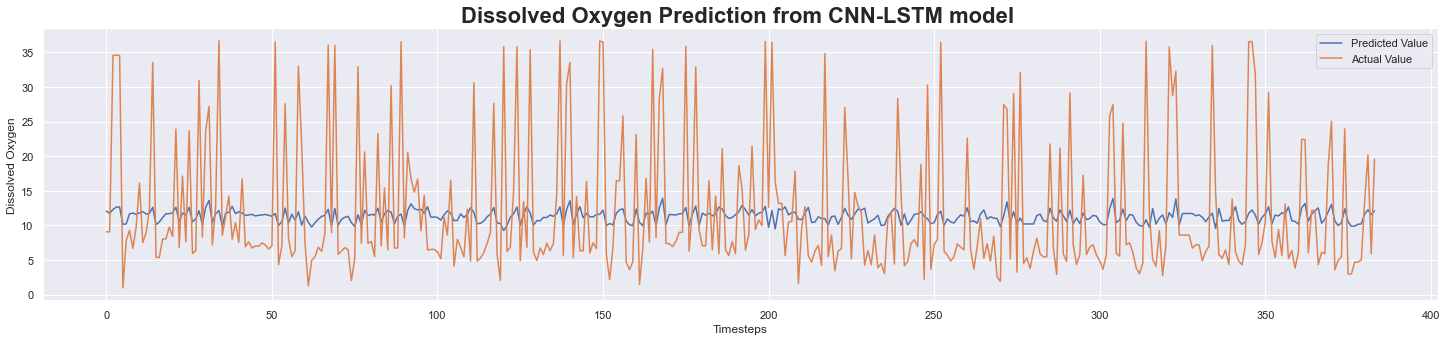

In [473]:
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('./Predictions/dissolvedOx_predictions.csv', index = None)

# Plot the predicted data vs. the actual data
# we will limit our plot to the first 200 predictions for better visualization
fig_verify = plt.figure(figsize=(25, 5))
# plt.plot(y_pred_test[-100:], label = 'Predicted Value')
# plt.plot(y_true_test[-100:], label = 'Actual Value')
plt.plot(y_pred_test, label = 'Predicted Value')
plt.plot(y_true_test, label = 'Actual Value')
plt.title('Dissolved Oxygen Prediction from CNN-LSTM model ', fontsize=22, fontweight='bold')
plt.ylabel('Dissolved Oxygen')
plt.xlabel('Timesteps')
plt.legend()
plt.show()
fig_verify.savefig("./Images/dissolvedOx_predictions.png")

Ammonia

In [426]:
# X_train = train_df.drop("Temperature",axis=1)
# X_train = train_df[['Turbidity','Ammonia','PH', 'Dissolved Oxygen']]
X_train = train_df[['Ammonia']]
y_train = train_df['Ammonia']
# X_test = val_df.drop("Temperature",axis=1)
X_test = val_df[['Ammonia']]

# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()

# Fit the scaler on your training data
# scaler.fit(X_train)

# X_train_norm = scaler.transform(X_train)
# X_test_norm = scaler.transform(X_test)

X_train_norm = X_train
X_test_norm = X_test

In [427]:
# we'll start out with a 2 minute input sequence and a one minute predictive horizon
seq_arrays = []
seq_labs = []
seq_length = 2
ph = 1


num_train_rows=train_df.shape[0]

#create list of sequence length Temperature readings
for start in range(0,num_train_rows-seq_length-ph):
    seq_arrays.append(X_train_norm[start:start+seq_length])
#     seq_arrays.append(train_df[feat_cols].iloc[start:start+seq_length].to_numpy())
    seq_labs.append([train_df['Ammonia'].iloc[start:start+seq_length+1].to_numpy()[-1]])

seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)

In [428]:
val_arrays = []
val_labs = []

num_test_rows=val_df.shape[0]

i=1

#create list of Temperature readings starting with a minimum of two readings
for start in range(2,num_test_rows):
    incoming_df=val_df[0:start] 
    
    if len(incoming_df) > seq_length: 
        
        val_arrays.append(X_test_norm[i:i+seq_length])
        val_labs.append([incoming_df['Ammonia'].iloc[i:i+seq_length+ph].to_numpy()[-1]])
        i+=1
        
    else:
        
        val_arrays.append(X_test_norm[0:len(incoming_df)])
        val_labs.append([incoming_df['Ammonia'].iloc[0:len(incoming_df)+ph].to_numpy()[-1]])
        
# use the pad_sequences function on your input sequences
val_arrays = tf.keras.preprocessing.sequence.pad_sequences(val_arrays, dtype='float32', padding='post',value=val_df["PH"].mean())     

#convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype = object).astype(np.float32)

In [429]:
print(val_arrays.shape,val_labs.shape,seq_arrays.shape,seq_labs.shape)

(384, 2, 1) (384, 1) (1541, 2, 1) (1541, 1)


In [430]:
from keras.layers import Conv1D, BatchNormalization
model_path = './Models/CNN_LSTM_model_ammonia.h5'
# build the network
nb_features = seq_arrays.shape[2]
nb_out = seq_labs.shape[1]
model = Sequential()

model.add(Conv1D(32,input_shape=(seq_length, nb_features),kernel_size=2, padding="causal",activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv1D(48,kernel_size=2,padding="causal",activation="relu",dilation_rate=2))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv1D(64,kernel_size=2,padding="causal",activation="relu",dilation_rate=4))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(LSTM(50))
model.add(Dropout(0.2))

model.add(Dense(units = nb_out))
model.add(Activation("linear"))
optimizer = keras.optimizers.Adam(learning_rate = 0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])
print(model.summary())

Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_165 (Conv1D)         (None, 2, 32)             96        
                                                                 
 batch_normalization_165 (Ba  (None, 2, 32)            128       
 tchNormalization)                                               
                                                                 
 dropout_224 (Dropout)       (None, 2, 32)             0         
                                                                 
 conv1d_166 (Conv1D)         (None, 2, 48)             3120      
                                                                 
 batch_normalization_166 (Ba  (None, 2, 48)            192       
 tchNormalization)                                               
                                                                 
 dropout_225 (Dropout)       (None, 2, 48)           

In [431]:
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=50,validation_split=0.05, verbose=2,
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0, patience=10, verbose=0, mode='min'),
keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True,mode='min', verbose=0)])
# list all data in history
print(history.history.keys())

Epoch 1/100
30/30 - 5s - loss: 26349118947328.0000 - mse: 26349118947328.0000 - val_loss: 0.0578 - val_mse: 0.0578 - 5s/epoch - 154ms/step
Epoch 2/100
30/30 - 0s - loss: 26349123141632.0000 - mse: 26349123141632.0000 - val_loss: 0.0150 - val_mse: 0.0150 - 230ms/epoch - 8ms/step
Epoch 3/100
30/30 - 0s - loss: 26349118947328.0000 - mse: 26349118947328.0000 - val_loss: 1.1228e-04 - val_mse: 1.1228e-04 - 374ms/epoch - 12ms/step
Epoch 4/100
30/30 - 0s - loss: 26349118947328.0000 - mse: 26349118947328.0000 - val_loss: 0.0092 - val_mse: 0.0092 - 214ms/epoch - 7ms/step
Epoch 5/100
30/30 - 0s - loss: 26349118947328.0000 - mse: 26349118947328.0000 - val_loss: 0.0496 - val_mse: 0.0496 - 167ms/epoch - 6ms/step
Epoch 6/100
30/30 - 0s - loss: 26349116850176.0000 - mse: 26349116850176.0000 - val_loss: 0.1242 - val_mse: 0.1242 - 165ms/epoch - 5ms/step
Epoch 7/100
30/30 - 0s - loss: 26349118947328.0000 - mse: 26349118947328.0000 - val_loss: 0.1502 - val_mse: 0.1502 - 172ms/epoch - 6ms/step
Epoch 8/100


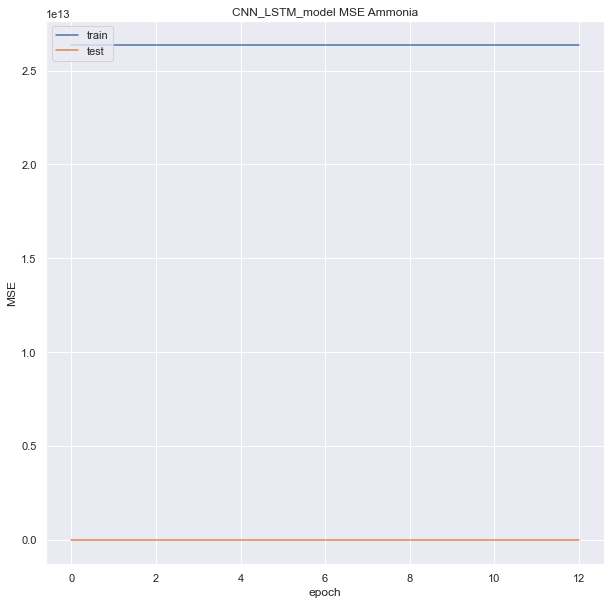

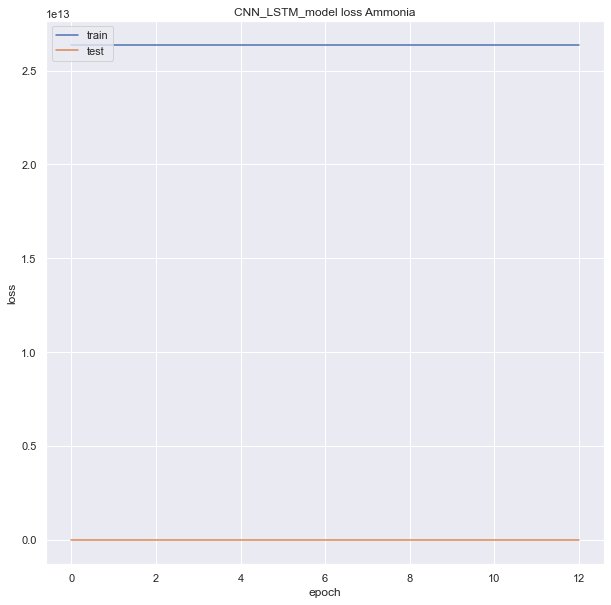

In [432]:
# summarize history for MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('CNN_LSTM_model MSE Ammonia')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("./Images/CNN_LSTM_mse_Ammonia.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN_LSTM_model loss Ammonia')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("./Images/CNN_LSTM_loss_ammonia.png")


12/12 - 0s - loss: 0.1361 - mse: 0.1361 - 226ms/epoch - 19ms/step

MSE: 0.13605667650699615
12/12 [==============================] - 1s 2ms/step


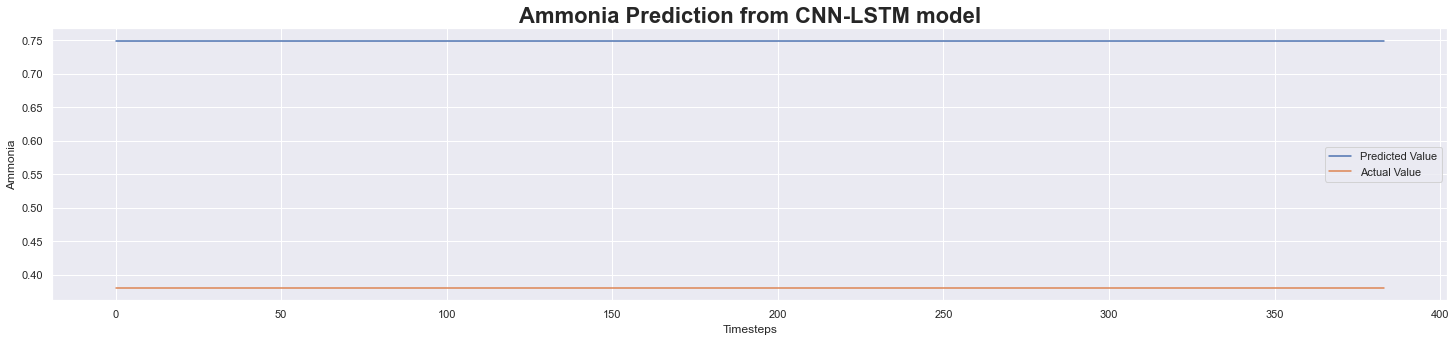

In [433]:
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('./Predictions/ammonia_predictions.csv', index = None)

# Plot the predicted data vs. the actual data
# we will limit our plot to the first 200 predictions for better visualization
fig_verify = plt.figure(figsize=(25, 5))
# plt.plot(y_pred_test[-100:], label = 'Predicted Value')
# plt.plot(y_true_test[-100:], label = 'Actual Value')
plt.plot(y_pred_test, label = 'Predicted Value')
plt.plot(y_true_test, label = 'Actual Value')
plt.title('Ammonia Prediction from CNN-LSTM model', fontsize=22, fontweight='bold')
plt.ylabel('Ammonia')
plt.xlabel('Timesteps')
plt.legend()
plt.show()
fig_verify.savefig("./Images/Ammonia_Predictions.png")

Nitrate

In [434]:
# X_train = train_df.drop("Temperature",axis=1)
# X_train = train_df[['Turbidity','Ammonia','PH', 'Dissolved Oxygen']]
X_train = train_df[['Nitrate']]
y_train = train_df['Nitrate']
# X_test = val_df.drop("Temperature",axis=1)
X_test = val_df[['Nitrate']]

# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()

# Fit the scaler on your training data
# scaler.fit(X_train)

# X_train_norm = scaler.transform(X_train)
# X_test_norm = scaler.transform(X_test)

X_train_norm = X_train
X_test_norm = X_test

In [435]:
# we'll start out with a 2 minute input sequence and a one minute predictive horizon
seq_arrays = []
seq_labs = []
seq_length = 2
ph = 1


num_train_rows=train_df.shape[0]

#create list of sequence length Temperature readings
for start in range(0,num_train_rows-seq_length-ph):
    seq_arrays.append(X_train_norm[start:start+seq_length])
#     seq_arrays.append(train_df[feat_cols].iloc[start:start+seq_length].to_numpy())
    seq_labs.append([train_df['Nitrate'].iloc[start:start+seq_length+1].to_numpy()[-1]])

seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)

In [436]:
val_arrays = []
val_labs = []

num_test_rows=val_df.shape[0]

i=1

#create list of Temperature readings starting with a minimum of two readings
for start in range(2,num_test_rows):
    incoming_df=val_df[0:start] 
    
    if len(incoming_df) > seq_length: 
        
        val_arrays.append(X_test_norm[i:i+seq_length])
        val_labs.append([incoming_df['Nitrate'].iloc[i:i+seq_length+ph].to_numpy()[-1]])
        i+=1
        
    else:
        
        val_arrays.append(X_test_norm[0:len(incoming_df)])
        val_labs.append([incoming_df['Nitrate'].iloc[0:len(incoming_df)+ph].to_numpy()[-1]])
        
# use the pad_sequences function on your input sequences
val_arrays = tf.keras.preprocessing.sequence.pad_sequences(val_arrays, dtype='float32', padding='post',value=val_df["PH"].mean())     

#convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype = object).astype(np.float32)

In [437]:
print(val_arrays.shape,val_labs.shape,seq_arrays.shape,seq_labs.shape)

(384, 2, 1) (384, 1) (1541, 2, 1) (1541, 1)


In [438]:
from keras.layers import Conv1D, BatchNormalization
model_path = './Models/CNN_LSTM_model_nitrate.h5'
# build the network
nb_features = seq_arrays.shape[2]
nb_out = seq_labs.shape[1]
model = Sequential()

model.add(Conv1D(32,input_shape=(seq_length, nb_features),kernel_size=2, padding="causal",activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv1D(48,kernel_size=2,padding="causal",activation="relu",dilation_rate=2))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# model.add(Conv1D(64,kernel_size=2,padding="causal",activation="relu",dilation_rate=4))
# model.add(BatchNormalization())
# model.add(Dropout(0.4))

model.add(LSTM(50))
model.add(Dropout(0.2))

model.add(Dense(units = nb_out))
model.add(Activation("linear"))
optimizer = keras.optimizers.Adam(learning_rate = 1)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])
print(model.summary())

Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_168 (Conv1D)         (None, 2, 32)             96        
                                                                 
 batch_normalization_168 (Ba  (None, 2, 32)            128       
 tchNormalization)                                               
                                                                 
 dropout_228 (Dropout)       (None, 2, 32)             0         
                                                                 
 conv1d_169 (Conv1D)         (None, 2, 48)             3120      
                                                                 
 batch_normalization_169 (Ba  (None, 2, 48)            192       
 tchNormalization)                                               
                                                                 
 dropout_229 (Dropout)       (None, 2, 48)           

In [439]:
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=500,validation_split=0.05, verbose=2,
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0, patience=10, verbose=0, mode='min'),
keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True,mode='min', verbose=0)])
# list all data in history
print(history.history.keys())

Epoch 1/100
3/3 - 5s - loss: 37646.4062 - mse: 37646.4062 - val_loss: 20461.0273 - val_mse: 20461.0273 - 5s/epoch - 2s/step
Epoch 2/100
3/3 - 0s - loss: 18391.3887 - mse: 18391.3887 - val_loss: 7700.6187 - val_mse: 7700.6187 - 244ms/epoch - 81ms/step
Epoch 3/100
3/3 - 0s - loss: 5591.1021 - mse: 5591.1021 - val_loss: 1618.8798 - val_mse: 1618.8798 - 189ms/epoch - 63ms/step
Epoch 4/100
3/3 - 0s - loss: 832.9675 - mse: 832.9675 - val_loss: 161.7856 - val_mse: 161.7856 - 133ms/epoch - 44ms/step
Epoch 5/100
3/3 - 0s - loss: 1624.5836 - mse: 1624.5836 - val_loss: 37.5185 - val_mse: 37.5185 - 194ms/epoch - 65ms/step
Epoch 6/100
3/3 - 0s - loss: 1522.4803 - mse: 1522.4803 - val_loss: 283.0497 - val_mse: 283.0497 - 95ms/epoch - 32ms/step
Epoch 7/100
3/3 - 0s - loss: 893.5173 - mse: 893.5173 - val_loss: 161.1297 - val_mse: 161.1297 - 97ms/epoch - 32ms/step
Epoch 8/100
3/3 - 0s - loss: 865.4861 - mse: 865.4861 - val_loss: 229.7538 - val_mse: 229.7538 - 157ms/epoch - 52ms/step
Epoch 9/100
3/3 - 0

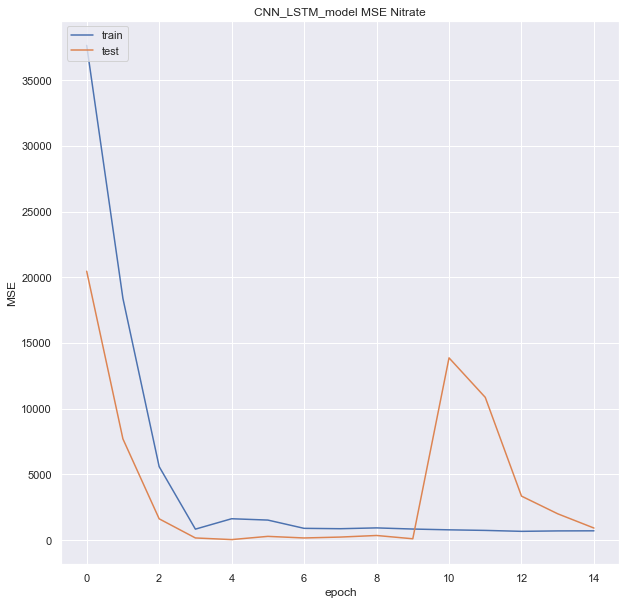

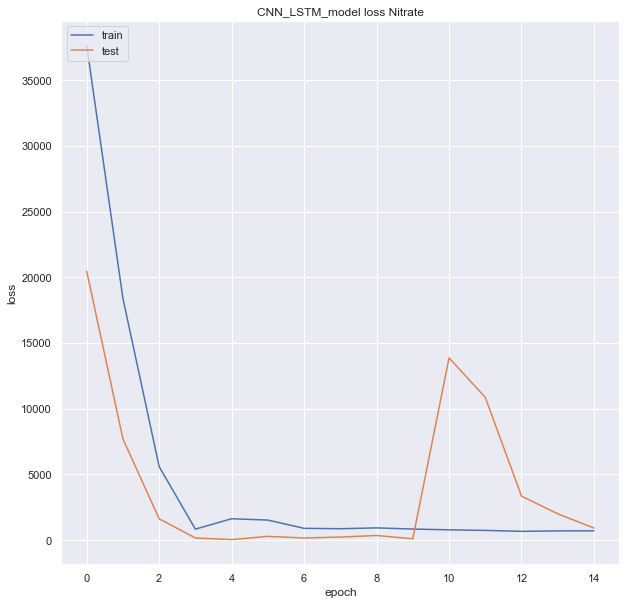

In [440]:
# summarize history for MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('CNN_LSTM_model MSE Nitrate')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("./Images/CNN_LSTM_mse_Nitrate.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN_LSTM_model loss Nitrate')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("./Images/CNN_LSTM_loss_nitrate.png")


12/12 - 0s - loss: 1565.3983 - mse: 1565.3983 - 50ms/epoch - 4ms/step

MSE: 1565.3983154296875
12/12 [==============================] - 1s 2ms/step


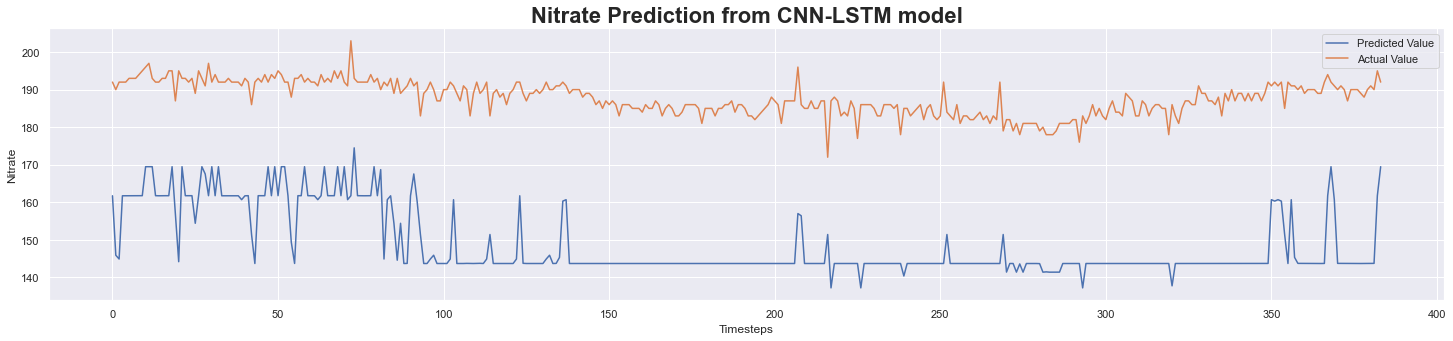

In [441]:
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('./Predictions/nitrate_predictions.csv', index = None)

# Plot the predicted data vs. the actual data
# we will limit our plot to the first 200 predictions for better visualization
fig_verify = plt.figure(figsize=(25, 5))
# plt.plot(y_pred_test[-100:], label = 'Predicted Value')
# plt.plot(y_true_test[-100:], label = 'Actual Value')
plt.plot(y_pred_test, label = 'Predicted Value')
plt.plot(y_true_test, label = 'Actual Value')
plt.title('Nitrate Prediction from CNN-LSTM model', fontsize=22, fontweight='bold')
plt.ylabel('Nitrate')
plt.xlabel('Timesteps')
plt.legend()
plt.show()
fig_verify.savefig("./Images/Nitrate_Predictions.png")

In [474]:
# Create new DataFrame with "cleaned_pond2" and append the predicted values to it for each timestep for each attribute

combined_df = pd.read_csv('../Data/cleaned_pond2.csv')
combined_df["Temperature_Predict"] = pd.read_csv('./Predictions/temperature_predictions.csv')
combined_df["PH_Predict"] = pd.read_csv('./Predictions/ph_predictions.csv')
combined_df["Turbidity_Predict"] = pd.read_csv('./Predictions/turbidity_predictions.csv')
combined_df["Dissolved Oxygen Predict"] = pd.read_csv('./Predictions/dissolvedOx_predictions.csv')
combined_df["Ammonia_Predict"] = pd.read_csv('./Predictions/ammonia_predictions.csv')
combined_df['Nitrate_Predict'] = pd.read_csv('./Predictions/nitrate_predictions.csv')

# Export the combined DataFrame to a CSV file
combined_df.to_csv('./Predictions/combined_pond.csv', index = None)
combined_df.to_csv('../Data/combined_pond.csv', index = None)
